In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import matplotlib as mpl
sys.path.append('../python/')
os.environ['MPLCONFIGDIR'] = '../mplstyles'


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

import numpy as np
#set up a plot 
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

# Integral Computations

The computations to create the contours in the previous book, `EpEq_2D_joint.ipynb`, worked only when the resolutions were increased by a factor of 10. This is probably because of difficulties in the `expband_EpEq_2D` function in `../python/prob_dist.py`. Here we try to compute the contours with the correct estimated SuperCDMS resolutions. 

In [2]:
#constants
V=4.0
eps=3.3/1000.0
F=10
F0=0.00001 #number to use when we want effectively zero Fano factor

#get baseline resolutions for SuperCDMS goal for iZIPs
sig0p = 0.050 #50 eV
sig0q = 0.100 #100 eV

Fer = 0.1 #Fano factor for ERs
#sigp and sigq functions for ERs
sigp = lambda E: np.sqrt(sig0p**2 + ((V/1000)**2/eps)*Fer*E)
sigq = lambda E: np.sqrt(sig0q**2 + eps*Fer*E)
sigpv = np.vectorize(sigp)
sigqv = np.vectorize(sigq)

#get an ER yield model
yer = lambda Er: 1

#get a yield model
import lindhard as lind

ynr_ev = lind.getLindhardGe()
ynr = lambda Er: ynr_ev(Er*1000)

Eee = lambda Er: ynr(Er)*Er

sigp_NR = lambda Er: sigp(Eee(Er))
sigq_NR = lambda Er: sigq(Eee(Er))
sigp_NRv = np.vectorize(sigp_NR)
sigq_NRv = np.vectorize(sigq_NR)

Now that we have the resolutions, we can compute the distributions for the ER and NR case. This is done below, along with a check of the distribution for a set of parameters ($E_{p0}$,$E_{q0}$,$E_{r0}$) which should be near a maximum on the distribution $P(E_p,E_q,E_r)$. When that function is evaluated at that point it should yield a non-zero value, and the value should not be exponentially small. 

In [3]:
#get the 2D resolution function
import prob_dist as pd

Pe = pd.EpEq_v2_2D_fast(sigp,sigq,V,eps,F0,yer) 
P = pd.EpEq_v2_2D_fast(sigp,sigq,V,eps,F,ynr) 

Er0=50
#print(ER(Er0+(V/(1000*eps))*Er0,Er0))
#print(NR(Er0+(V/(1000*eps))*ynr(Er0)*Er0,ynr(Er0)*Er0))

Ep0 = Er0+(V/(1000*eps))*ynr(Er0)*Er0
Eq0 = ynr(Er0)*Er0
print(Er0)
print(Ep0)
print(Eq0)
print(sigp_NR(Er0))
print(sigp(Er0))

print(P(Ep0,Eq0,Er0))
#print(Pe(Ep0,Eq0,Ep0-width))
#print(Pe(Ep0,Eq0,Ep0+width))

50
68.38161023366122
15.164828442770503
0.0992604860630074
0.16353111093129724
1.253765688028364


We then try to compute the integral of the function $P(E_p,E_q,E_r)$ over the last argument, $E_r$. This is a very sharp integral and is prone to failure in the `quad` function, we therefore carefully construct a small region around the maximum (which was found **_empirically_** to be $E_r = E_{r0} = E_{p0} - (V/\epsilon)E_{q0}$. It seems the integral converges for these limits of integration. 

In [4]:
from scipy.integrate import quad
from scipy.integrate import quadrature

alpha=1/100.0

width = 5*sigp(Er0)
#width = 11
print(width)


pnr = lambda Er: (1/alpha)*np.exp(-alpha*Er)

Ep_Eqdist = lambda Er,Ep,Eq: P(Ep,Eq,Er)*pnr(Er)
print(np.amax([0,Er0-width]))
intmin = np.amax([0,Er0-width])
intmax=Er0+width
print(intmin)
print(intmax)
print(Ep_Eqdist(Er0,Ep0,Eq0))
print(Ep_Eqdist(Er0-width,Ep0,Eq0))
print(Ep_Eqdist(Er0+width,Ep0,Eq0))

    
#norm = quad(Ep_Eqdist, 7,200,limit=100,args=(Ep0,Eq0,))
#norm = quadrature(Ep_Eqdist, 7,200,args=(Ep0,Eq0,))

#print(norm)

#norm = quad(Ep_Eqdist, intmin,intmax,limit=100,args=(Ep0,Eq0,))
#norm = quadrature(Ep_Eqdist, intmin,intmax,args=(Ep0,Eq0,))
norm = quad(Ep_Eqdist, intmin,intmax,args=(Ep0,Eq0,))

print(norm)

0.8176555546564862
49.18234444534352
49.18234444534352
50.81765555465648
76.04473298849075
0.0011158956760048738
0.001315369136056132
(33.159233516941185, 1.4265202463725757e-08)


Since the results from the `quad` function are prone to errors, we explicitly check if the returned integral is the **_maximum_** over the range of integration bounds. Basically, the bounds should be $-\infty$ to $\infty$ but the integral is too sharp to compute there and the returned value from `quad` becomes anomalously low if the bounds are too wide. 

We are **tacilty assuming that the maximum plausible number returned from `quad` is the correct value**.

In [5]:
from scipy.optimize import fmin

f = lambda x,y: -quad(Ep_Eqdist,x,y,limit=100,args=(Ep0,Eq0,))[0]
#f = lambda x,y: -quadrature(Ep_Eqdist,x,y,maxiter=100,args=(Ep0,Eq0,))[0]

def fvec(x,f=f):
    return f(x[0],x[1])

#below is an attempt to find SOME value for which the integral converges
#it was unsuccessful
#the problem is that there are starting values for the limits wich yield exactly 0.0 for
#the integral, since this happens over a wide range the minimizer misses the points for which the
#integral is non-zero. 
#delval=0
#while delval==0:
#    print('{} {} {} {}'.format(intmin,intmax,delval,fvec([intmin,intmax])))
#    intmin-=0.01
#    intmax+=0.01
#    if(np.abs(fvec([intmin,intmax]))>0.0001):
#        print('breaking')
#        delval=1
#        break

print(fvec([intmin,intmax]))
    
minimum = fmin(fvec,[intmin,intmax],ftol=1e8)

-33.159233516941185
Optimization terminated successfully.
         Current function value: -33.159320
         Iterations: 34
         Function evaluations: 88


The minimization procedure is meant to find the maximum range of integration that does not fail to give a plausible answer. We can also check if integrating slightly outside this region will cause failure in the `quad` routine. 

In [6]:
delta = 46
norm = quad(Ep_Eqdist, minimum[0]-delta,minimum[1]+delta,args=(Ep0,Eq0,))


print(norm)

(33.15931997815605, 7.240139056428202e-09)


In [7]:
delta = 5
norm = quad(Ep_Eqdist, minimum[0]-delta-(V/(1000*eps)),minimum[1]+delta-(V/(1000*eps)),args=(Ep0,Eq0+1,))

print(norm)

norm = quad(Ep_Eqdist, minimum[0]-delta,minimum[1]+delta,args=(Ep0,Eq0+1,))

print(norm)

norm = quad(Ep_Eqdist, minimum[0]-delta-(V/(1000*eps)),minimum[1]+delta-(V/(1000*eps)),args=(Ep0,Eq0+2,))

print(norm)

norm = quad(Ep_Eqdist, minimum[0]-delta,minimum[1]+delta,args=(Ep0,Eq0+2,))

print(norm)

(4.736535335148518, 1.021831146393303e-09)
(4.736535335152912, 4.640787837517131e-12)
(0.01080136047631935, 1.3733483536063845e-14)
(0.010801360476303187, 1.6778908613653484e-14)


The above two cells show that after the optimization even a very large perterbation to the width of the integration range (46 keV!) leads to the same answer for the integral. So apparently this optimization procedure does not get return the very edge of the region that gives plausible integrals. NOTE: just above a delta of 46 keV, we start to get NaN for answers of this integral. 

The cells also show that if we move away from the central parameters $E_{p0}$ and $E_{q0}$ by 1 keV in the q variable, we need not correct the central value via the equation $E_r = E_p - (V/\epsilon)E_q$, the same value is obtained to a high enough accuracy. This is to try to answer the question of where the maximum in $E_r$ is of the 3-dimensional function $P(E_p,E_q,E_r)$ given arbitrary values for $E_p$ and $E_q$. We still don't exactly know the answer, but it seems the integral may be reasonably insensitive to this. 

# Mapping Out the Convergence Region

Since it seems plausible that computing the peaked integral about the center $E_{r0}$ with a width to the integration region set by 5$\sigma_p$ is a hearty strategy, we want to map out the region of convergence as a function of the value of $E_{r0}$. 

In [8]:
# make a function of the standard width

width_func = lambda Er: 5*sigp(Er)
with0 = lambda Er: sigp(Er)

#make a vector

In [9]:
print(np.sqrt(-1))

nan


/home/phys/villaa/python/anaconda3/envs/py365/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


# Plot $E_p$-$E_q$ Contours for SNOLAB Resolutions

Here, since we think we have made the convergence of the integral in `expband_EpEq_2D` more hearty, we attempt to plot these bands for ER and $^{252}$Cf spectra. 

In [10]:
#get the distributions for Er and Nr bands
ER = pd.expband_EpEq_2D(Pe,1/1000.0,5,V,eps,sigp) #last argument is an empirical range of integration.
NR = pd.expband_EpEq_2D(P,1/18.0,5,V,eps,sigp)

In [11]:
print(ER(Ep0,Eq0)) #remember parameters were for NR band
print(NR(Ep0,Eq0))

0.0
0.6118854664260409


In [12]:
Etest=1.5
x = np.linspace(0.0, 3*Etest, 100)
y = np.linspace(0.0, 2*Etest, 100)

X, Y = np.meshgrid(x, y)
PER_v = np.vectorize(ER)
PNR_v = np.vectorize(NR)
Znr_band = PNR_v(X,Y)
Zer_band = PER_v(X,Y)

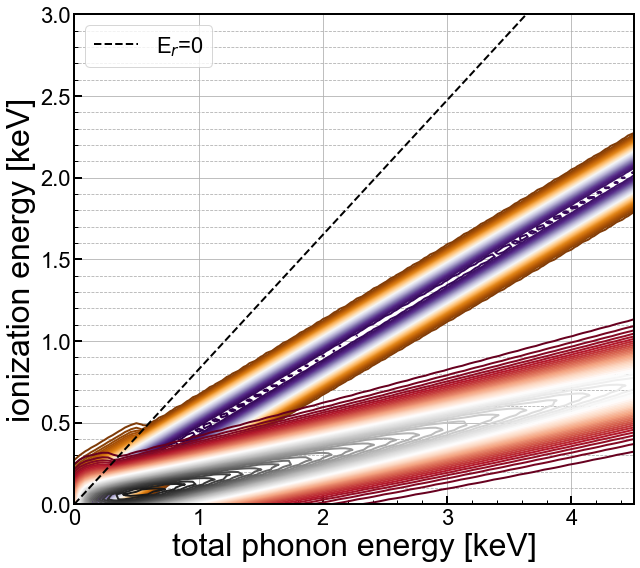

In [13]:
#set up a 2d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#draw a line where the estimate Ep-(V/eps)Eq for Er gets badly behaved
bline = lambda Ep: ((1000*eps)/V)*Ep
Xp = np.arange(0,3*Etest,0.1)


#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
ax1.plot(Xp, bline(Xp),color='k',linestyle='--',linewidth=2,label='E$_r$=0')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
ax1.contour(X, Y, Zer_band, 50,cmap='PuOr');
ax1.contour(X, Y, Znr_band, 50,cmap='RdGy');
#ax1.plot(Xhy,fhy(Xhy),label='Max proability',color='goldenrod',linestyle='--')


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0.0, 3*Etest) 
ax1.set_ylim(0.0,2*Etest)
ax1.set_xlabel('total phonon energy [keV]',**axis_font)
ax1.set_ylabel('ionization energy [keV]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

# The $E_r$<0 Region

The version of `expband_EpEq_2D` that we're working with uses a representative phonon resolution to compute the range of integration that the function returned from that call uses to compute the 2-dimensional density function. 

It seems we now have bounds for that integral that will reliably produce a "plausible" value for the integral, the question is if the bounds allow the value of the integral to achieve near-equivalence to the true value when the boundaries are 0 to $\infty$. 

For this it makes sense to construct another function which uses the procedure tested above to calculate the total integral, by maximizing over the integral boundaries. 

In [14]:
import imp
imp.reload(pd)
ER_slow = lambda Ep,Eq: pd.expband_EpEq_2D_slow(Ep,Eq,Pe,1/1000.0,5,V,eps,sigp) #last argument is an empirical range of integration.
NR_slow = lambda Ep,Eq: pd.expband_EpEq_2D_slow(Ep,Eq,P,1/18.0,5,V,eps,sigp)

tEp=2.0
tEq=0.25

import time
print('slow function: ')
start = time.time()
print(NR_slow(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))
print('fast function: ')
start = time.time()
print(NR(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))

tEp=0.25
tEq=0.25

import time
print('slow function: ')
start = time.time()
print(NR_slow(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))
print('fast function: ')
start = time.time()
print(NR(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))

slow function: 
[1.408752192885995, 1.985187201053399]
[0.36126999 3.06127743]
37.70297763748229
5.572561740875244 s
fast function: 
37.6267117183115
0.018750905990600586 s
slow function: 
[0.0, 0.25]
[-0.00298535  0.59541016]
5.317325884170742
1.384582281112671 s
fast function: 
4.440298610692544
0.01869487762451172 s


This new code `expband_EpEq_2D_slow` is, as expected, very slow. It is more than two orders of magnitude slower than the original. In some cases it seems to return answers that are within 1% of the original answer. However in a case where $E_r$ reconstructed is clearly less than zero, the answers differ significantly. 

It seems out of the question to calculate the whole function with the slow procedure. So, perhaps we can try to find a "widthfac" that is "safe" for those points where the reconstructed $E_r$ is less than zero.

In [15]:
ER_new = pd.expband_EpEq_2D(Pe,1/1000.0,10,V,eps,sigp) #last argument is an empirical range of integration.
NR_new = pd.expband_EpEq_2D(P,1/18.0,10,V,eps,sigp)

tEp=2.0
tEq=0.25

import time
print('slow function: ')
start = time.time()
print(NR_slow(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))
print('fast function: ')
start = time.time()
print(NR_new(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))

tEp=0.25
tEq=0.25

import time
print('slow function: ')
start = time.time()
print(NR_slow(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))
print('fast function: ')
start = time.time()
print(NR_new(tEp,tEq)) 
end = time.time()
print('{} s'.format(end - start))

slow function: 
[1.408752192885995, 1.985187201053399]
[0.36126999 3.06127743]
37.70297763748229
5.560771465301514 s
fast function: 
37.702977637063995
0.042855262756347656 s
slow function: 
[0.0, 0.25]
[-0.00298535  0.59541016]
5.317325884170742
1.382871389389038 s
fast function: 
5.317325852798132
0.030997753143310547 s


In [16]:
PER_new_v = np.vectorize(ER_new)
PNR_new_v = np.vectorize(NR_new)
Znr_band_new = PNR_new_v(X,Y)
Zer_band_new = PER_new_v(X,Y)

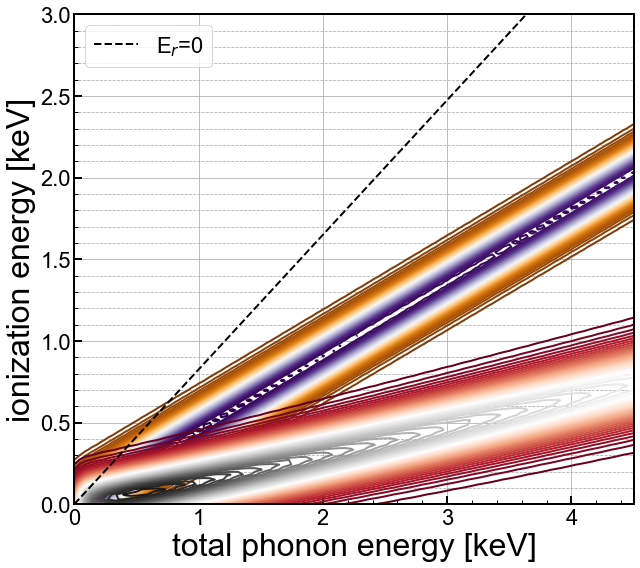

In [17]:
#set up a 2d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#draw a line where the estimate Ep-(V/eps)Eq for Er gets badly behaved
bline = lambda Ep: ((1000*eps)/V)*Ep
Xp = np.arange(0,3*Etest,0.1)


#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
ax1.plot(Xp, bline(Xp),color='k',linestyle='--',linewidth=2,label='E$_r$=0')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
ax1.contour(X, Y, Zer_band_new, 50,cmap='PuOr');
ax1.contour(X, Y, Znr_band_new, 50,cmap='RdGy');
#ax1.plot(Xhy,fhy(Xhy),label='Max proability',color='goldenrod',linestyle='--')


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0.0, 3*Etest) 
ax1.set_ylim(0.0,2*Etest)
ax1.set_xlabel('total phonon energy [keV]',**axis_font)
ax1.set_ylabel('ionization energy [keV]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

It seems like simply increaseing the "widthfac" parameter to `expband_EpEq_2D` will produce **_plausible_** results. I still think it makes sense to think of ways to calculate the whole function either analytically or with the integral maximization method used in `expband_EpEq_2D_slow`. 